In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display

# 데이터 불러오기

In [2]:
from data_preprocess import preprocessing

In [3]:
base_path = '2022-03-07/'
file_paths = [
    base_path + 'bestshots.json', 
    base_path + 'items.json', 
    base_path +'categories.json', 
    base_path +'products.json'
]

In [4]:
products_df_4, products_df_b = preprocessing(file_paths)
products_df_4.shape, products_df_b.shape

/Users/ruo/Desktop/codestates/CP2/data_preprocess.py:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates_df['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


((4211, 10), (46576, 10))

### 유저-아이템 매트릭스

In [7]:
# 아이템(가구)가 전문가에 의해 사용된 횟수만큼 점수를 부여 
matrix_4 = products_df_4.pivot_table('awesome_score', index='projectId', columns='name', aggfunc='count').fillna(0).round().astype(int)
matrix_b = products_df_b.pivot_table('awesome_score', index='projectId', columns='name', aggfunc='count').fillna(0).round().astype(int)

matrix_4.shape, matrix_b.shape

((250, 2199), (3160, 7752))

In [21]:
matrix_b

name,(-)400 확장형 전신거울(거치형) 화이트,(-)QLED TV 더프레임 189cm(75) KQ75LST03AFXKR(스탠드)(베이지),(-)VARDI 장스탠드 E26 KS2099F 5090.6984 (그레이),(-)모듈 랙 E1 투명,(-)모듈 랙 E3 옐로우,(-)모듈 콘솔 G-1 (화이트),(-)몬스테라 라탄바구니 세트 (M),(-)샤이나 구스 장스탠드 (화이트),(-)오로라 단스탠드 (무광로즈골드),(-)오로라 단스탠드 (샤이닝실버),...,휴에디션 침대 SS (다크그레이),흑백 창문 그림 인테리어 액자 포스터 (A3),흔들리는 촛불 LED 무빙 캔들 5x12.5,흔들리는 촛불 LED 무빙 캔들 5x15,흔들리는 촛불 LED 무빙 캔들 5x8,히알린 일자 장식장 (오크),히트 렌지대 주방수납장 전자렌지 밥솥 선반 미니 정수기다이 6colors (화이트),히트펌프 스탠다드 의류건조기 대용량 10kg DHP24412MG,히트펌프 스팀플러스(스팀+향기) 의류건조기 대용량 11kg DHP24414WST (화이트),힐링 대자리 (그레이) (150x200)
projectId,,,,,,,,,,,,,,,,,,,,,
X03kkmq3F0385EA5C764AE6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X0DG-R365501D4F10C44991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X0F4LrPB3C3113053B540A7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X0I2BuKAEB365CDB09F4B96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X0Ntnsv80F53E9104804254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XzoeG9K4E19B2A3C44342AF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XzqGokw4C96DFD0E9634FE9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Xzrao7B8FC2F792A389477B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_b_T = matrix_b.transpose()
df_4_T = matrix_4.transpose()

# KNN 기반 협업필터링 추천시스템 구현

### 코사인 유사도

In [23]:
# 아이템 간 유사도 산출
from sklearn.metrics.pairwise import cosine_similarity

item_sim_b = cosine_similarity(df_b_T, df_b_T)

In [25]:
item_sim_df_b = pd.DataFrame(item_sim_b, index=matrix_b.columns, columns=matrix_b.columns)
item_sim_df_b

name,(-)400 확장형 전신거울(거치형) 화이트,(-)QLED TV 더프레임 189cm(75) KQ75LST03AFXKR(스탠드)(베이지),(-)VARDI 장스탠드 E26 KS2099F 5090.6984 (그레이),(-)모듈 랙 E1 투명,(-)모듈 랙 E3 옐로우,(-)모듈 콘솔 G-1 (화이트),(-)몬스테라 라탄바구니 세트 (M),(-)샤이나 구스 장스탠드 (화이트),(-)오로라 단스탠드 (무광로즈골드),(-)오로라 단스탠드 (샤이닝실버),...,휴에디션 침대 SS (다크그레이),흑백 창문 그림 인테리어 액자 포스터 (A3),흔들리는 촛불 LED 무빙 캔들 5x12.5,흔들리는 촛불 LED 무빙 캔들 5x15,흔들리는 촛불 LED 무빙 캔들 5x8,히알린 일자 장식장 (오크),히트 렌지대 주방수납장 전자렌지 밥솥 선반 미니 정수기다이 6colors (화이트),히트펌프 스탠다드 의류건조기 대용량 10kg DHP24412MG,히트펌프 스팀플러스(스팀+향기) 의류건조기 대용량 11kg DHP24414WST (화이트),힐링 대자리 (그레이) (150x200)
name,,,,,,,,,,,,,,,,,,,,,
(-)400 확장형 전신거울(거치형) 화이트,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.144338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(-)QLED TV 더프레임 189cm(75) KQ75LST03AFXKR(스탠드)(베이지),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(-)VARDI 장스탠드 E26 KS2099F 5090.6984 (그레이),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(-)모듈 랙 E1 투명,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.064550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(-)모듈 랙 E3 옐로우,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히알린 일자 장식장 (오크),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
히트 렌지대 주방수납장 전자렌지 밥솥 선반 미니 정수기다이 6colors (화이트),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
히트펌프 스탠다드 의류건조기 대용량 10kg DHP24412MG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
search_item = '(-)400 확장형 전신거울(거치형) 화이트'

item_sim_df_b[search_item].sort_values(ascending=False)[:10]

name
(-)400 확장형 전신거울(거치형) 화이트              1.000000
스프링 플로어 장스탠드SS-2000A_4colors (블랙)     0.707107
1500-2단 와이드 책장 책꽂이 선반 수납장 (화이트)       0.707107
데일리책장 공간박스 3단 3칸 2colors (화이트)        0.577350
플레인 E0등급 800 선반 수납장 (높은형) (화이트)       0.500000
계단형 천정몰딩_오크                           0.500000
데일리 오븐토스터기(화이트)                       0.500000
뉴트럴 체어 (화이트)                          0.500000
스밈 400 행거형 수납 옷장 6colors (All 화이트)    0.471405
에센자 미니 C30 (블랙)                       0.353553
Name: (-)400 확장형 전신거울(거치형) 화이트, dtype: float64

In [28]:
def predict_rating(ratings_arr, item_sim_arr):
    ratings_pred = ratings_arr.dot(item_sim_arr)/np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [30]:
# 아이템 별 스코어 예측하기
ratings_pred = predict_rating(matrix_b.values, item_sim_df_b.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=matrix_b.index, columns=matrix_b.columns)
ratings_pred_matrix

name,(-)400 확장형 전신거울(거치형) 화이트,(-)QLED TV 더프레임 189cm(75) KQ75LST03AFXKR(스탠드)(베이지),(-)VARDI 장스탠드 E26 KS2099F 5090.6984 (그레이),(-)모듈 랙 E1 투명,(-)모듈 랙 E3 옐로우,(-)모듈 콘솔 G-1 (화이트),(-)몬스테라 라탄바구니 세트 (M),(-)샤이나 구스 장스탠드 (화이트),(-)오로라 단스탠드 (무광로즈골드),(-)오로라 단스탠드 (샤이닝실버),...,휴에디션 침대 SS (다크그레이),흑백 창문 그림 인테리어 액자 포스터 (A3),흔들리는 촛불 LED 무빙 캔들 5x12.5,흔들리는 촛불 LED 무빙 캔들 5x15,흔들리는 촛불 LED 무빙 캔들 5x8,히알린 일자 장식장 (오크),히트 렌지대 주방수납장 전자렌지 밥솥 선반 미니 정수기다이 6colors (화이트),히트펌프 스탠다드 의류건조기 대용량 10kg DHP24412MG,히트펌프 스팀플러스(스팀+향기) 의류건조기 대용량 11kg DHP24414WST (화이트),힐링 대자리 (그레이) (150x200)
projectId,,,,,,,,,,,,,,,,,,,,,
X03kkmq3F0385EA5C764AE6,0.000000,0.000000,0.001300,0.000000,0.017490,0.000000,0.001781,0.000000,0.000685,0.000000,...,0.000000,0.007913,0.000000,0.000000,0.000000,0.014796,0.000000,0.000000,0.000000,0.013
X0DG-R365501D4F10C44991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002003,0.000000,0.000000,0.000000,...,0.000000,0.001618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
X0F4LrPB3C3113053B540A7,0.000000,0.000000,0.000000,0.013582,0.000000,0.000000,0.001063,0.000000,0.001306,0.008456,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
X0I2BuKAEB365CDB09F4B96,0.004557,0.000000,0.011324,0.000000,0.011893,0.000000,0.003784,0.000000,0.003585,0.000000,...,0.000000,0.001401,0.000000,0.000000,0.000000,0.007516,0.000000,0.000000,0.000000,0.000
X0Ntnsv80F53E9104804254,0.009164,0.000000,0.000000,0.004891,0.000000,0.000000,0.012689,0.000000,0.003044,0.009657,...,0.000000,0.021179,0.000000,0.000000,0.016247,0.000000,0.021219,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XzoeG9K4E19B2A3C44342AF,0.000000,0.006294,0.012367,0.001898,0.000000,0.000000,0.006716,0.013523,0.002821,0.003051,...,0.000000,0.004578,0.000000,0.020135,0.004836,0.002387,0.003691,0.000000,0.003236,0.000
XzqGokw4C96DFD0E9634FE9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.005999,0.000000,0.021563,0.000000,0.000
Xzrao7B8FC2F792A389477B,0.000000,0.003173,0.000733,0.000000,0.000000,0.002198,0.004628,0.000000,0.001546,0.007802,...,0.000000,0.007158,0.000000,0.000000,0.000000,0.000000,0.000000,0.014387,0.000000,0.000


In [31]:
from sklearn.metrics import mean_squared_error

# 전문가가 사용한 아이템에 대해서만 예측 성능 평가 mse를 구함
def get_mse(pred, actual):
    # 스코어가 있는 실제 아이템만 추출
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [33]:
# 아이템 기반 모든 최근접 이웃 mse
get_mse(ratings_pred, matrix_b.values)

0.9075067118544327

In [34]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)
    
    # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
            
    return pred

In [35]:
ratings_pred = predict_rating_topsim(matrix_b.values, item_sim_df_b.values, n=20)
print('아이템 기반 최근점 top-20 이웃 MSE: ', get_mse(ratings_pred, matrix_b.values))

/var/folders/9_/rnj5svk11p1157tkdv28yb6r0000gn/T/ipykernel_87425/2094699859.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
/var/folders/9_/rnj5svk11p1157tkdv28yb6r0000gn/T/ipykernel_87425/2094699859.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))


아이템 기반 최근점 top-20 이웃 MSE:  0.6688042736532901


In [36]:
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=matrix_b.index, columns=matrix_b.columns)
ratings_pred_matrix

name,(-)400 확장형 전신거울(거치형) 화이트,(-)QLED TV 더프레임 189cm(75) KQ75LST03AFXKR(스탠드)(베이지),(-)VARDI 장스탠드 E26 KS2099F 5090.6984 (그레이),(-)모듈 랙 E1 투명,(-)모듈 랙 E3 옐로우,(-)모듈 콘솔 G-1 (화이트),(-)몬스테라 라탄바구니 세트 (M),(-)샤이나 구스 장스탠드 (화이트),(-)오로라 단스탠드 (무광로즈골드),(-)오로라 단스탠드 (샤이닝실버),...,휴에디션 침대 SS (다크그레이),흑백 창문 그림 인테리어 액자 포스터 (A3),흔들리는 촛불 LED 무빙 캔들 5x12.5,흔들리는 촛불 LED 무빙 캔들 5x15,흔들리는 촛불 LED 무빙 캔들 5x8,히알린 일자 장식장 (오크),히트 렌지대 주방수납장 전자렌지 밥솥 선반 미니 정수기다이 6colors (화이트),히트펌프 스탠다드 의류건조기 대용량 10kg DHP24412MG,히트펌프 스팀플러스(스팀+향기) 의류건조기 대용량 11kg DHP24414WST (화이트),힐링 대자리 (그레이) (150x200)
projectId,,,,,,,,,,,,,,,,,,,,,
X03kkmq3F0385EA5C764AE6,0.0,0.0,0.0,0.0,0.017490,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.013366
X0DG-R365501D4F10C44991,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
X0F4LrPB3C3113053B540A7,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
X0I2BuKAEB365CDB09F4B96,0.0,0.0,0.0,0.0,0.011893,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
X0Ntnsv80F53E9104804254,0.0,0.0,0.0,0.0,0.000000,0.0,0.033624,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XzoeG9K4E19B2A3C44342AF,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.013523,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
XzqGokw4C96DFD0E9634FE9,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.023919,0.0,0.000000
Xzrao7B8FC2F792A389477B,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [42]:
user_rating_id = matrix_b.loc['X03kkmq3F0385EA5C764AE6', :]
user_rating_id[user_rating_id > 0].sort_values(ascending=False)[:10]

name
LG UHD TV 75UN7850GNA 75인치 울트라HD (벽걸이형)    1
루치아 플러스 스툴 큐브 (그레이)                        1
소프트 모먼트 암막커튼 긴창 (크림베이지) (140x230)          1
알로카시아 공기정화식물                               1
코코 패브릭 3인 소파 (베이지)                         1
화이트 정사각 LED 방등 화이트                         1
Name: X03kkmq3F0385EA5C764AE6, dtype: int64

In [46]:
products_df_b[products_df_b['projectId'] == 'X03kkmq3F0385EA5C764AE6']['name'].values.tolist()

['화이트 정사각 LED 방등 화이트',
 '코코 패브릭 3인 소파 (베이지)',
 '알로카시아 공기정화식물',
 'LG UHD TV 75UN7850GNA 75인치 울트라HD (벽걸이형)',
 '소프트 모먼트 암막커튼 긴창 (크림베이지) (140x230)',
 '루치아 플러스 스툴 큐브 (그레이)']

# 아이템 추천

In [49]:
# 사용해보지 않은 아이템 리스트를 객체로 반환하는 함수
def get_unseen_items(ratings_matrix, userId):
    
    user_rating = ratings_matrix.loc[userId, :]
    already_seen = user_rating[user_rating > 0].index.tolist()
    items_list = ratings_matrix.columns.tolist()
    
    unseen_list = [item for item in items_list if item not in already_seen]
    return unseen_list

In [60]:
def recomm_item_by_userid(pred_df, userId, unseen_list, top_n=10):
    recomm_items = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_items

In [61]:
search_userId = 'X03kkmq3F0385EA5C764AE6'

unseen_list_b = get_unseen_items(matrix_b, search_userId)

recomm_items_b = recomm_item_by_userid(ratings_pred_matrix, search_userId, unseen_list_b, top_n=10)

recomm_items_b_df = pd.DataFrame(data=recomm_items_b.values, index=recomm_items_b.index, columns=['pred_score'])

recomm_items_b_df

,pred_score
name,
DK010 3.5인/3인용 풀커버 패브릭 발수 소파 베이지,0.122736
하이드웰 꾸밈 LED 책상(스페셜파티션) (내추럴오크),0.108946
FAMIAN 4인 식탁세트 B형 (브라운),0.108180
아미르 4인 기능성 카시미라 패브릭 소파(스툴포함) (민트),0.106159
신제품 모던라이프 앱구동 BLDC 선풍기 화이트,0.106111
2000-2단 와이드 책장 책꽂이 선반 수납장 (메이플화이트),0.102151
타미 3인 패브릭소파 네이비,0.088709
우드 탁상 테이블 화장대 스탠드 거울 (내추럴),0.082210
다니엘 4인 천연면피 소가죽 소파 10colors (스툴제외) (크림아이보리),0.065460


In [62]:
# 추천된 아이템 이미지 보여주기
def show_rec_items(df, search_userId, rec_df):
    item_list = rec_df.index.tolist()
    for i, item in enumerate(item_list):
        print(item)
        images = df[df['name'] == item]['images'].values.tolist()[0]
        try:
            res = requests.get(images[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except:
            print('이미지 없음\n')
        print(f'{i+1}순위 추천 아이템 : {item}')

DK010 3.5인/3인용 풀커버 패브릭 발수 소파 베이지


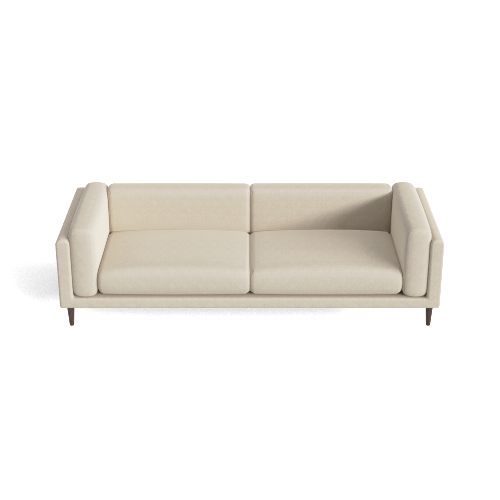

1순위 추천 아이템 : DK010 3.5인/3인용 풀커버 패브릭 발수 소파 베이지
하이드웰 꾸밈 LED 책상(스페셜파티션) (내추럴오크)


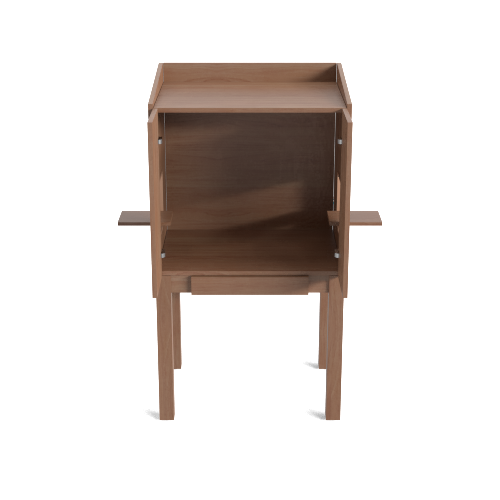

2순위 추천 아이템 : 하이드웰 꾸밈 LED 책상(스페셜파티션) (내추럴오크)
FAMIAN 4인 식탁세트 B형 (브라운)


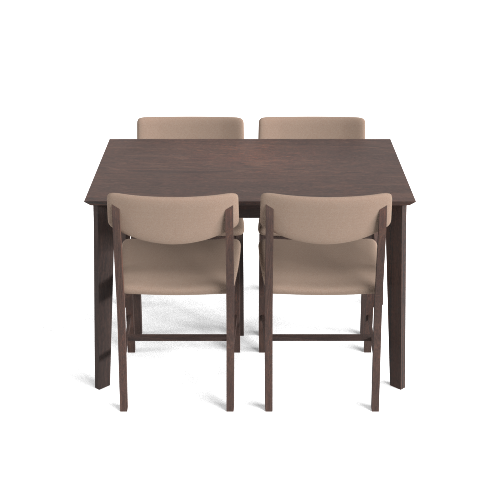

3순위 추천 아이템 : FAMIAN 4인 식탁세트 B형 (브라운)
아미르 4인 기능성 카시미라 패브릭 소파(스툴포함) (민트)


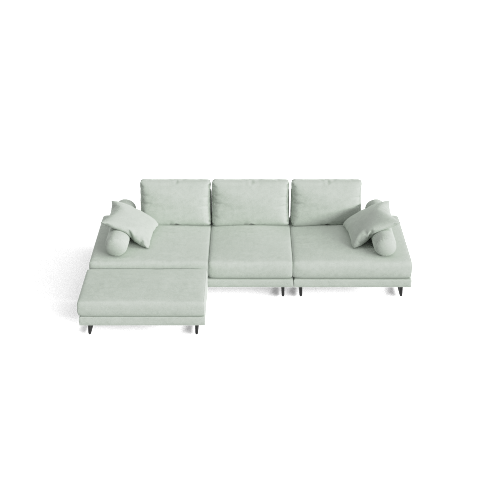

4순위 추천 아이템 : 아미르 4인 기능성 카시미라 패브릭 소파(스툴포함) (민트)
신제품 모던라이프 앱구동 BLDC 선풍기 화이트


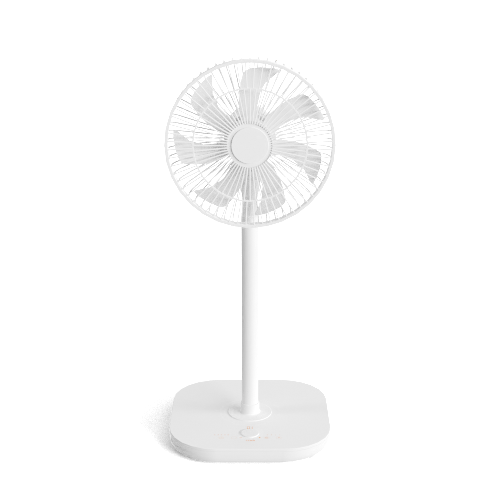

5순위 추천 아이템 : 신제품 모던라이프 앱구동 BLDC 선풍기 화이트
2000-2단 와이드 책장 책꽂이 선반 수납장 (메이플화이트)


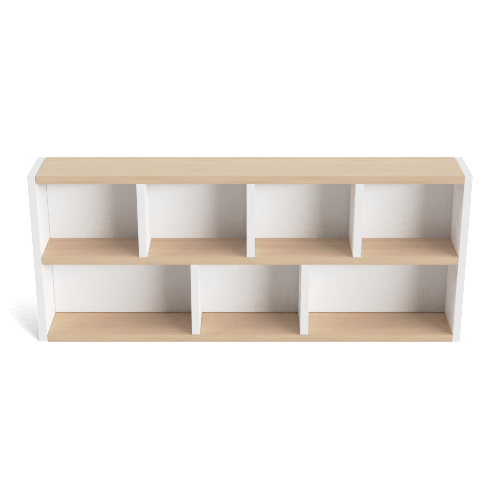

6순위 추천 아이템 : 2000-2단 와이드 책장 책꽂이 선반 수납장 (메이플화이트)
타미 3인 패브릭소파 네이비


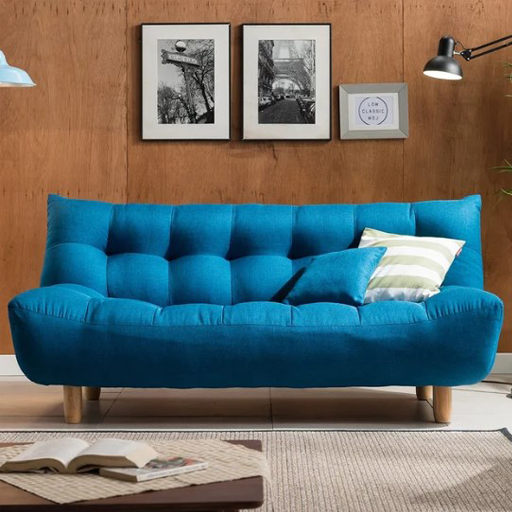

7순위 추천 아이템 : 타미 3인 패브릭소파 네이비
우드 탁상 테이블 화장대 스탠드 거울 (내추럴)


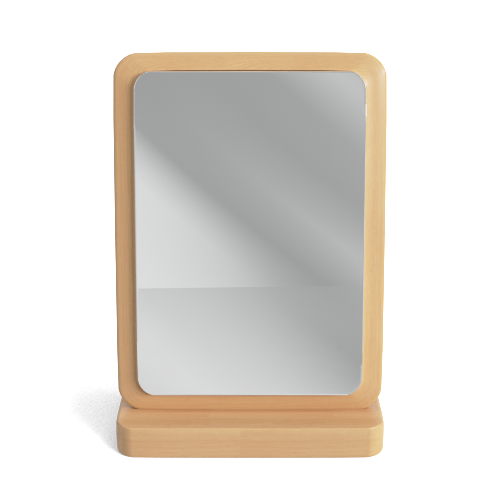

8순위 추천 아이템 : 우드 탁상 테이블 화장대 스탠드 거울 (내추럴)
다니엘 4인 천연면피 소가죽 소파 10colors (스툴제외) (크림아이보리)


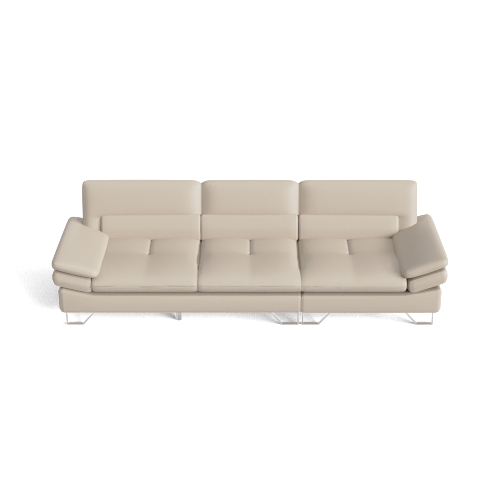

9순위 추천 아이템 : 다니엘 4인 천연면피 소가죽 소파 10colors (스툴제외) (크림아이보리)
몬드리안 침대 프레임 호텔식 침대 (K) (크림화이트)


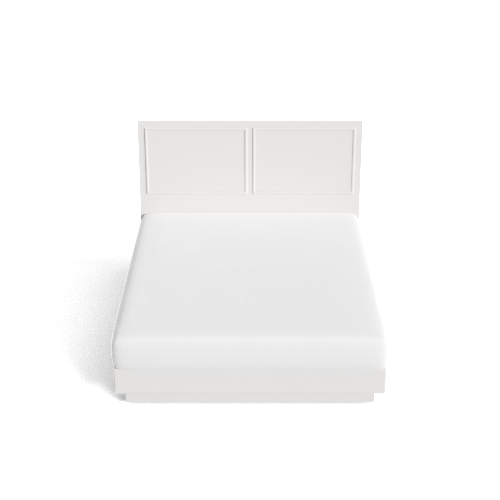

10순위 추천 아이템 : 몬드리안 침대 프레임 호텔식 침대 (K) (크림화이트)


In [63]:
show_rec_items(products_df_b, search_userId, recomm_items_b_df)

In [64]:
# 선택된 유저가 이미 가지고 있는 기존 아이템 이미지 보여주기
def show_user_list(df, search_userId):
    for name, images in df[df['projectId'] == search_userId][['name', 'images']].values.tolist():
        try:
            res = requests.get(images[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except:
            pass
        print(name)

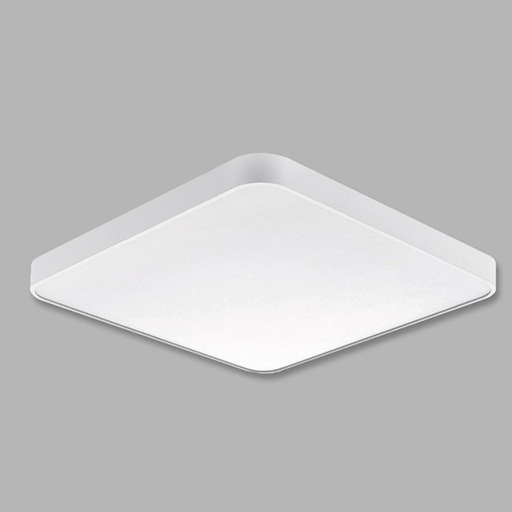

화이트 정사각 LED 방등 화이트


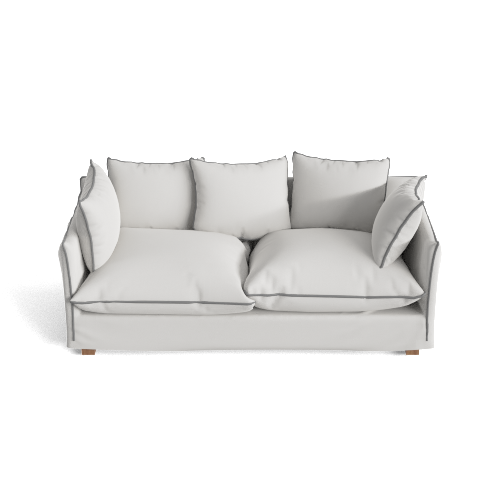

코코 패브릭 3인 소파 (베이지)


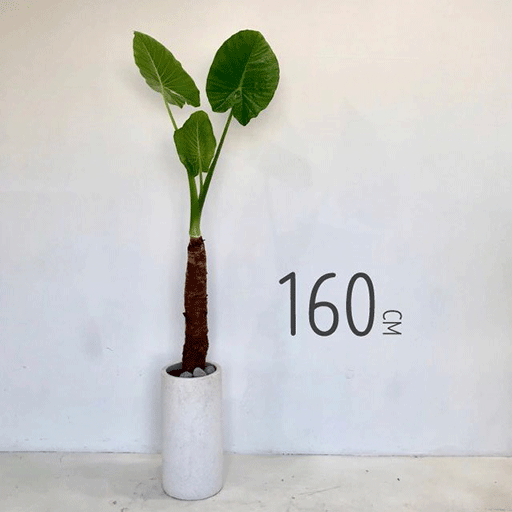

알로카시아 공기정화식물


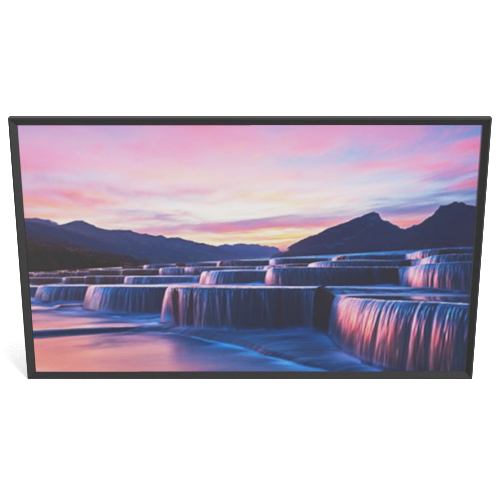

LG UHD TV 75UN7850GNA 75인치 울트라HD (벽걸이형)


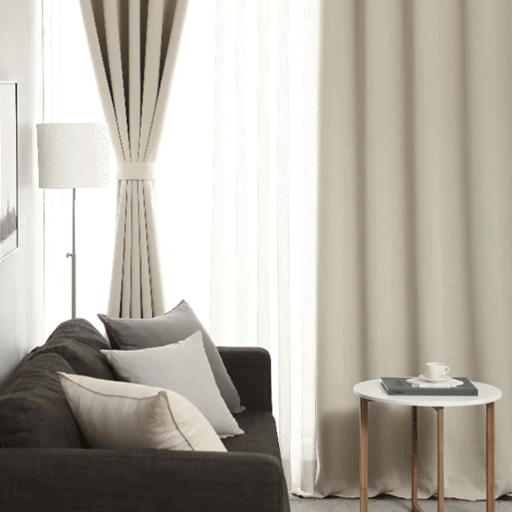

소프트 모먼트 암막커튼 긴창 (크림베이지) (140x230)


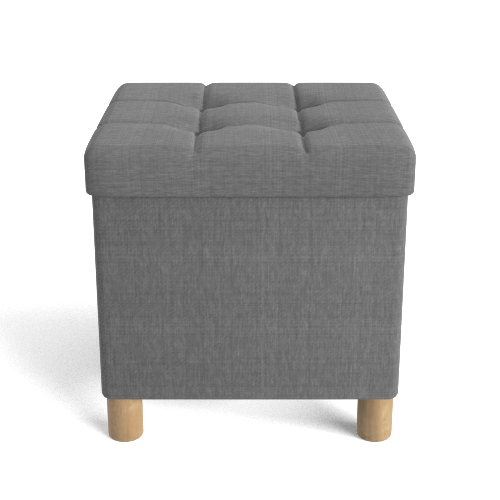

루치아 플러스 스툴 큐브 (그레이)


In [65]:
show_user_list(products_df_b, search_userId)